# ✈️ FlightOnTime — Predição de Atrasos em Voos

O **FlightOnTime** é um projeto de *Data Science* e *Back-End* voltado para prever a probabilidade de um voo **decolar no horário ou com atraso**, utilizando dados históricos de aviação civil.  
Ele faz parte de um desafio educacional cujo objetivo é construir um **MVP preditivo** capaz de apoiar passageiros, companhias aéreas e aeroportos na tomada de decisão.

## Descrição do projeto

### 🎯 Objetivo do Projeto

Criar um modelo de classificação binária que, a partir de informações de um voo — como companhia aérea, origem, destino, horário e distância — estima se ele será **Pontual (0)** ou **Atrasado (1)**, retornando também a probabilidade associada.

---

### 🧠 Pipeline de Data Science

O notebook conduz as principais etapas do fluxo de ciência de dados:

1. **ETL e limpeza dos dados**  
   - Carregamento, padronização e enriquecimento das informações de voos.

2. **Engenharia de variáveis (Feature Engineering)**  
   - Extração de atributos relevantes, como:  
     hora do voo, dia da semana, distância, aeroportos, companhia aérea.

3. **Modelagem preditiva**  
   - Testes com algoritmos supervisionados (ex.: Logistic Regression, Random Forest).

4. **Avaliação do modelo**  
   - Métricas como Acurácia, Precisão, Recall e F1-score.

5. **Exportação do modelo treinado**  
   - Serialização via `joblib` para uso pela API de Back-End.

---

### 🛠️ Integração com a API

O modelo gerado neste notebook será consumido por uma **API REST em Java (Spring Boot)**, que disponibilizará o endpoint:

```
POST /predict
```

Retornando:

```json
{
  "previsao": "Atrasado",
  "probabilidade": 0.78
}
```

---

### 📌 Sobre o Dataset

O projeto utiliza um conjunto de dados contendo informações reais de voos, incluindo:

- companhia aérea  
- aeroporto de origem e destino  
- data e horário de partida  
- distância do trecho  
- status de atraso  

As funções de ETL foram previamente desenvolvidas para garantir limpeza, consistência e rastreabilidade.

## 🚀 Início do Notebook

A partir daqui, o notebook executa o fluxo completo de preparação, análise e modelagem, resultando em um modelo leve, funcional e pronto para produção no MVP do FlightOnTime.

### Imports Globais

In [40]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix

import automlx
from automlx import init # type: ignore

### Preprocessamento e Carga

Execute as funções abaixo para carregar os dados de fonte local ou para baixar, preprocessar e salvar os dados a partir da base de dados de vôos da ANAC (Agência Nacional de Aviação Civil).  
- Os dados são salvos em ./dados/  
- A função `processar_dados` acessa toda a base de dados da ANAC a partir de Janeiro/2001 até Outubro/2025.

In [2]:
def processar_dados(save: bool = True) -> pd.DataFrame:
    """
    Executa o pipeline completo de ETL dos dados de voos a partir da base de dados de vôos da ANAC (Agência Nacional de Aviação Civil).

    Baixa os arquivos CSV brutos, realiza o pré-processamento, consolida os dados
    em um único DataFrame e salva automaticamente os resultados em formatos
    CSV e Parquet no diretório ./data/, com versionamento por timestamp.

    Parâmetros
    ----------
    **save** : bool, opcional
        Indica se o DataFrame resultante deve ser salvo em disco.
        Padrão é True, o que significa que os arquivos serão salvos
        automaticamente.

    Retorna
    -------
    pd.DataFrame
        Dataset consolidado e pré-processado.
    """
    from etl.etl import getUrls, preprocess_csvs
        
    urls = getUrls()
    dataset = preprocess_csvs(urls)
    if save:
      from etl.etl import save_df
      save_df(dataset, timestamp=True)

    return dataset   


def carregar_dados(filename: str) -> pd.DataFrame:
    """
    Carrega um dataset de voos previamente pré-processado a partir de um arquivo Parquet
    e aplica conversões de tipo para colunas categóricas e de data/hora.

    Parâmetros
    ----------
    filename : str
        Nome-base do arquivo Parquet localizado em ./data/.
        Não inclua a extensão ".parquet".

    Retorna
    -------
    pd.DataFrame
        Dataset carregado com colunas categóricas convertidas para `category`
        e colunas de data/hora convertidas para `datetime`, pronto para análise
        ou modelagem.
    """
    # Função interna para converter colunas categóricas
    def parse_categoricals(df: pd.DataFrame) -> pd.DataFrame:
        categorical_columns = [
            "Empresa Aérea",
            "Código Tipo Linha",
            "Aeródromo Origem",
            "Aeródromo Destino",
        ]
        for col in categorical_columns:
            df[col] = df[col].astype('category')
        
        return df
    
    # Função interna para converter colunas de data/hora
    def parse_datetime(df: pd.DataFrame) -> pd.DataFrame:
        datetime_columns = [
            "Partida Prevista",
            "Partida Real",
        ]
        for col in datetime_columns:
            df[col] = pd.to_datetime(df[col], format="mixed", dayfirst=True, errors='coerce')
        
        return df
    
    filepath = f'{os.getcwd()}/data/{filename}.parquet'
    print(f"Carregando dataset local de: ./data/{filename}.parquet")
    dataset = pd.read_parquet(filepath)
    dataset = parse_categoricals(dataset)
    dataset = parse_datetime(dataset)
    print("🏁 Dataset carregado com sucesso!")

    return dataset

#### Preprocessar com origem externa

Baixa e executa o preprocessamento em tempo de execução através da base de dados abertos da ANAC.  
Link: https://sistemas.anac.gov.br/dadosabertos/Voos%20e%20opera%C3%A7%C3%B5es%20a%C3%A9reas/Voo%20Regular%20Ativo%20%28VRA%29/  

Para mais informações sobre o processo, consulte a documentação do módulo etl.

In [3]:
# Código comentado por segurança
# Descomente a linha abaixo para executar o pipeline ETL completo

# df = processar_dados()

#### Preprocessar com origem local

Exemplo de nome de arquivo local:  
```python
filename = "vra_master_20250101_153000"
```

- Não necessita informar o caminho do arquivo e extensão.  
- Caminho default: ./data
- Extensão default: .parquet

In [4]:
filename = "vra_master_20251213_172116"
df = carregar_dados(filename=filename)

Carregando dataset local de: ./data/vra_master_20251213_172116.parquet
🏁 Dataset carregado com sucesso!


#### Visualizações

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13564548 entries, 0 to 13564547
Data columns (total 6 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Empresa Aérea      category      
 1   Código Tipo Linha  category      
 2   Aeródromo Origem   category      
 3   Aeródromo Destino  category      
 4   Partida Prevista   datetime64[ns]
 5   Partida Real       datetime64[ns]
dtypes: category(4), datetime64[ns](2)
memory usage: 297.6 MB


In [6]:
df

,Empresa Aérea,Código Tipo Linha,Aeródromo Origem,Aeródromo Destino,Partida Prevista,Partida Real
0,NES,R,SBSN,SBBE,2000-01-01 18:04:00.000,2000-01-01 16:46:00
1,NES,R,SBMO,SBRF,2000-01-01 17:30:00.000,2000-01-01 19:10:00
2,TBA,N,SBRJ,SBSP,2000-01-01 11:24:00.000,2000-01-01 11:41:00
3,VRG,N,SBGR,SBFI,2000-01-01 20:54:00.000,2000-01-01 21:12:00
4,VRG,N,SBSV,SBBR,2000-01-01 17:20:00.000,2000-01-01 18:30:00
...,...,...,...,...,...,...
13564543,AZU,N,SBSV,SBKP,2025-10-02 02:50:00.100,2025-10-02 02:43:00
13564544,TAM,N,SBFZ,SBGL,2025-10-02 18:20:00.000,2025-10-02 18:34:00
13564545,TAM,N,SBBR,SBRJ,2025-10-24 09:35:00.000,2025-10-24 09:29:00
13564546,GLO,N,SBBE,SBBR,2025-10-22 05:00:00.000,2025-10-22 04:48:00


#### Refinar ETL

Nesta seção verificamos se algum dado nulo ou indesejado passou pelo processo bruto de ETL e aperfeiçoamos o dataset.

In [7]:
def check_nulls(df: pd.DataFrame, col: str) -> None:
    nulls_notice = f'Coluna "{col}" possui {df[col].isna().sum()} valores nulos.'
    print(nulls_notice)
    return

def check_uniques(df: pd.DataFrame, col: str) -> None:
    print(f'Coluna "{col}":')
    print(f'{df[col].unique()}\n')
    return

##### Verificando Nulos

In [8]:
for col in df.columns:
    check_nulls(df, col)

Coluna "Empresa Aérea" possui 0 valores nulos.
Coluna "Código Tipo Linha" possui 250 valores nulos.
Coluna "Aeródromo Origem" possui 0 valores nulos.
Coluna "Aeródromo Destino" possui 0 valores nulos.
Coluna "Partida Prevista" possui 0 valores nulos.
Coluna "Partida Real" possui 0 valores nulos.


##### Verificando Uniques

In [9]:
for col in df.columns:
    check_uniques(df, col)

Coluna "Empresa Aérea":
['NES', 'TBA', 'VRG', 'RSL', 'TAM', ..., 'BPC', 'MLM', 'IWY', 'ARU', 'AEB']
Length: 250
Categories (250, object): ['1DE', '1ED', 'AAL', 'ABB', ..., 'VVC', 'WAL', 'WEB', 'WFL']

Coluna "Código Tipo Linha":
['R', 'N', 'I', 'L', 'E', 'C', 'G', 'H', NaN, 'X']
Categories (9, object): ['C', 'E', 'G', 'H', ..., 'L', 'N', 'R', 'X']

Coluna "Aeródromo Origem":
['SBSN', 'SBMO', 'SBRJ', 'SBGR', 'SBSV', ..., 'LMML', 'MUGM', 'MTCH', 'EGPK', 'FNBJ']
Length: 622
Categories (622, object): ['1AON', '2NHT', '6ASO', 'CYHM', ..., 'ZHCC', 'ZSAM', 'ZSHC', 'ZUUU']

Coluna "Aeródromo Destino":
['SBBE', 'SBRF', 'SBSP', 'SBFI', 'SBBR', ..., 'LMML', 'KSDF', 'FNBJ', 'MUGM', 'MTCH']
Length: 624
Categories (624, object): ['2NHT', '6ASO', 'BIKF', 'CYHM', ..., 'ZSAM', 'ZSHC', 'ZSNJ', 'ZUUU']

Coluna "Partida Prevista":
<DatetimeArray>
[       '2000-01-01 18:04:00',        '2000-01-01 17:30:00',
        '2000-01-01 11:24:00',        '2000-01-01 20:54:00',
        '2000-01-01 17:20:00',        '

##### Eliminando os Nulos

In [10]:
df = df.dropna(subset="Código Tipo Linha")
check_nulls(df, "Código Tipo Linha")

Coluna "Código Tipo Linha" possui 0 valores nulos.


#### Engenharia de Features

Nesta seção transformamos as colunas `Partida Prevista` e `Partida Real` em features separadas:
- `Data do Voo` *datetime64[ns]*  
    - Data em que o vôo ocorreu.  

- `Horario_min` *int16*  
    - Horário do dia em que o vôo ocorreu em *minutos*.  
    *0 = 00:00, 1439 = 23:59*
- `Dia da Semana` *int8*  
    - Dia da semana em que o vôo ocorreu.  
    *0 = Segunda, 6 = Domingo*

A variável dependente (X) `Atrasado` é gerada a partir da comparação entre `Partida Prevista` e `Partida Real`.  

Por fim, eliminamos as variáveis originais `Partida Prevista` e `Partida Real`.

##### Data do Vôo

In [11]:
# Ativa o modo copy-on-write do pandas para evitar SettingWithCopyWarning
pd.options.mode.copy_on_write = True

df['Data do Voo'] = df['Partida Prevista'].dt.date
df['Data do Voo'] = pd.to_datetime(df['Data do Voo'], dayfirst=True, errors='coerce') # Transforma em Datetime

##### Horário do Vôo

In [12]:
# 0 = 0:00, 1439 = 23:59
df['Horario_min'] = (
    df['Partida Prevista'].dt.hour * 60 + # type: ignore
    df['Partida Prevista'].dt.minute # type: ignore
).astype('int16')

##### Dia da Semana

In [13]:
# 0 = Segunda, 6 = Domingo
df['Dia da Semana'] = df['Partida Prevista'].dt.weekday.astype('int8') # type: ignore

##### Atrasado (X)

In [14]:
# 1 = Atrasado, 0 = No Horario
df['Atrasado'] = (df['Partida Real'] > df['Partida Prevista']).astype('int8')

##### Eliminando Variáveis Originais

In [15]:
df = df.drop(columns=["Partida Prevista", "Partida Real"])

##### Verificando

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13564298 entries, 0 to 13564547
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Empresa Aérea      category      
 1   Código Tipo Linha  category      
 2   Aeródromo Origem   category      
 3   Aeródromo Destino  category      
 4   Data do Voo        datetime64[ns]
 5   Horario_min        int16         
 6   Dia da Semana      int8          
 7   Atrasado           int8          
dtypes: category(4), datetime64[ns](1), int16(1), int8(2)
memory usage: 349.3 MB


In [17]:
df

,Empresa Aérea,Código Tipo Linha,Aeródromo Origem,Aeródromo Destino,Data do Voo,Horario_min,Dia da Semana,Atrasado
0,NES,R,SBSN,SBBE,2000-01-01,1084,5,0
1,NES,R,SBMO,SBRF,2000-01-01,1050,5,1
2,TBA,N,SBRJ,SBSP,2000-01-01,684,5,1
3,VRG,N,SBGR,SBFI,2000-01-01,1254,5,1
4,VRG,N,SBSV,SBBR,2000-01-01,1040,5,1
...,...,...,...,...,...,...,...,...
13564543,AZU,N,SBSV,SBKP,2025-10-02,170,3,0
13564544,TAM,N,SBFZ,SBGL,2025-10-02,1100,3,1
13564545,TAM,N,SBBR,SBRJ,2025-10-24,575,4,0
13564546,GLO,N,SBBE,SBBR,2025-10-22,300,2,0


In [18]:
for col in df.columns:
    check_nulls(df, col)

Coluna "Empresa Aérea" possui 0 valores nulos.
Coluna "Código Tipo Linha" possui 0 valores nulos.
Coluna "Aeródromo Origem" possui 0 valores nulos.
Coluna "Aeródromo Destino" possui 0 valores nulos.
Coluna "Data do Voo" possui 0 valores nulos.
Coluna "Horario_min" possui 0 valores nulos.
Coluna "Dia da Semana" possui 0 valores nulos.
Coluna "Atrasado" possui 0 valores nulos.


#### Visualizando (Y)

Aqui analisamos a distribuição dos vôos atrasados no histórico de vôos observados.  

- Aproximadamente 8.5 milhões de vôos foram pontuais.  
- Aproximadamente 5 milhões de vôos atrasaram, totalizando aproximadamente 36.45% dos vôos observados.  

Atrasado
0    8619548
1    4944750
Name: count, dtype: int64
Atrasado
0    0.635458
1    0.364542
Name: proportion, dtype: float64


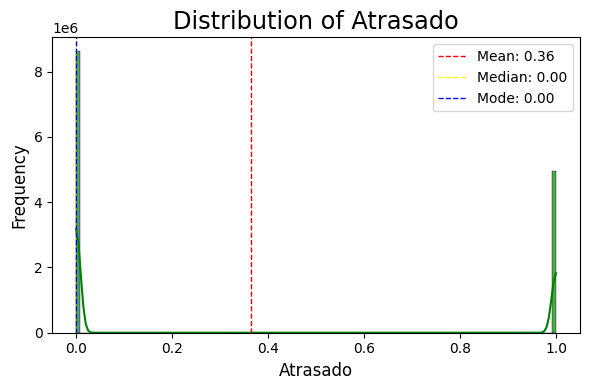

In [19]:
from utils.plot_feature import plot_feature
print(df['Atrasado'].value_counts())
print(df['Atrasado'].value_counts(normalize=True))
plot_feature(df, 'Atrasado')

#### Separando X e Y

Aqui separaremos as features (X) da variável alvo (Y).

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['Atrasado']),
    df['Atrasado'],
    test_size=0.3,
    random_state=42,
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9495008, 7), (4069290, 7), (9495008,), (4069290,))

In [21]:
X_train.head()

,Empresa Aérea,Código Tipo Linha,Aeródromo Origem,Aeródromo Destino,Data do Voo,Horario_min,Dia da Semana
8753506,TAM,N,SBSP,SBRJ,2018-06-30,960,5
7015371,TAM,N,SBGR,SBCF,2015-03-25,1050,2
13150057,TAM,N,SBSV,SBBR,2025-05-06,335,1
115957,VSP,N,SBGL,SBSV,2000-11-19,1164,6
2839697,GLO,N,SBGR,SBNT,2011-03-25,660,4


In [22]:
y_train.head()

8753506     0
7015371     0
13150057    0
115957      1
2839697     1
Name: Atrasado, dtype: int8

#### Modelagem

Para o processo de modelagem, decidimos usar a moderna biblioteca [Oracle AutoMLx](https://docs.oracle.com/en-us/iaas/tools/automlx/latest/latest/index.html), que automatiza os processos de `Seleção de Algoritmo`, `Sampling Adaptativo`, `Seleção de Features` e `Ajuste de Hiperparâmetros`, resultando num processo facilitado e com melhores métricas no modelo final.  

In [23]:
init(engine='local')

##### Referência de Pipeline:
Deletar depois **

```python
custom_pipeline = automlx.Pipeline(
    task='classification',
    model_list=[                 # Specify the models you want the AutoMLx to consider
        'LogisticRegression',
        'LGBMClassifier',
        'GaussianNB'
    ],
    n_algos_tuned=2,             # Choose how many models to tune
    min_features=[               # Specify minimum features to force the model to use. It can take 3 possible types of values:
        'native-country',        # If int, 0 < min_features <= n_features,
        'marital-status',              # If float, 0 < min_features <= 1.0, 1.0 means disabling feature selection
        'education-num'          # If list, names of features to keep, for example ['a', 'b'] means keep features 'a' and 'b'
    ],
    adaptive_sampling=False,     # Disable or enable Adaptive Sampling step. Default to `True`
    preprocessing=True,          # Disable or enable Preprocessing step. Default to `True`
    search_space={               # You can specify the hyper-parameters and ranges we search
        'LGBMClassifier': {
            'learning_rate': {'range': [0.01, 10], 'type': 'continuous'},
            'boosting_type': {'range': ['gbdt', 'dart'], 'type': 'categorical'},
        },
    },
    max_tuning_trials=2,         # The maximum number of tuning trials. Can be integer or Dict (max number for each model)
    score_metric='f1_macro',     # Any scikit-learn metric or a custom function
)

est1 = custom_pipeline.fit(
    X_train,
    y_train,
    # X_val,
    # y_val,
    time_budget= 20,    # Specify time budget in seconds
    cv='auto'           # Automatically pick a good cross-validation (cv) strategy for the user's dataset.
                        # Ignored if X_valid and y_valid are provided.
                        # Can also be:
                        #   - An integer (For example, to use 5-fold cross validation)
                        #   - A list of data indices to use as splits (for advanced, such as time-based splitting)
)
```

##### Custom Pipeline

In [ ]:
# Referência de Pipeline:
# Deletar depois **

# custom_pipeline = automlx.Pipeline(
#     task='classification',
#     model_list=[                 # Specify the models you want the AutoMLx to consider
#         'LogisticRegression',
#         'LGBMClassifier',
#         'GaussianNB'
#     ],
#     n_algos_tuned=2,             # Choose how many models to tune
#     min_features=[               # Specify minimum features to force the model to use. It can take 3 possible types of values:
#         'native-country',        # If int, 0 < min_features <= n_features,
#         'marital-status',              # If float, 0 < min_features <= 1.0, 1.0 means disabling feature selection
#         'education-num'          # If list, names of features to keep, for example ['a', 'b'] means keep features 'a' and 'b'
#     ],
#     adaptive_sampling=False,     # Disable or enable Adaptive Sampling step. Default to `True`
#     preprocessing=True,          # Disable or enable Preprocessing step. Default to `True`
#     search_space={               # You can specify the hyper-parameters and ranges we search
#         'LGBMClassifier': {
#             'learning_rate': {'range': [0.01, 10], 'type': 'continuous'},
#             'boosting_type': {'range': ['gbdt', 'dart'], 'type': 'categorical'},
#         },
#     },
#     max_tuning_trials=2,         # The maximum number of tuning trials. Can be integer or Dict (max number for each model)
#     score_metric='f1_macro',     # Any scikit-learn metric or a custom function
# )

# est1 = custom_pipeline.fit(
#     X_train,
#     y_train,
#     # X_val,
#     # y_val,
#     time_budget= 20,    # Specify time budget in seconds
#     cv='auto'           # Automatically pick a good cross-validation (cv) strategy for the user's dataset.
#                         # Ignored if X_valid and y_valid are provided.
#                         # Can also be:
#                         #   - An integer (For example, to use 5-fold cross validation)
#                         #   - A list of data indices to use as splits (for advanced, such as time-based splitting)
# )

##### Default Pipeline

In [ ]:
# est1 = automlx.Pipeline(task='classification', score_metric='recall') # type: ignore
# est1.fit(X_train, y_train)

[2025-12-21 15:58:58,611] [automlx.interface] Dataset shape: (9495008,7)
[2025-12-21 15:58:59,445] [automlx.data_transform] Running preprocessing. Number of features: 8
[2025-12-21 15:59:00,868] [automlx.data_transform] Preprocessing completed. Took 1.423 secs
[2025-12-21 15:59:00,923] [automlx.process] Running Model Generation
[2025-12-21 15:59:00,969] [automlx] Provided model (TorchMLPClassifier) is not supported.Supported models are: ['CatBoostClassifier', 'LGBMClassifier', 'SVC', 'AdaBoostClassifier', 'DecisionTreeClassifier', 'ExtraTreesClassifier', 'GaussianNB', 'GradientBoostingClassifier', 'KNeighborsClassifier', 'LinearSVC', 'LogisticRegressionClassifier', 'RandomForestClassifier', 'XGBClassifier']
[2025-12-21 15:59:00,972] [automlx.process] KNeighborsClassifier is disabled. The KNeighborsClassifier model is only recommended for datasets with less than 10000 samples and 1000 features.
[2025-12-21 15:59:00,974] [automlx.process] SVC is disabled. The SVC model is only recommende

In [26]:
y_proba = est1.predict_proba(X_test)
score_default = roc_auc_score(y_test, y_proba[:, 1])

print(f'Roc_auc score em dados de teste: {score_default}')

Roc_auc score em dados de teste: 0.7439467925916992


#### Análise do Processo de otimização do AutoMLx

Nesta seção analisamos o processo de otimização executado pelo AutoMLx de forma a compreender melhor o processo de modelagem e garantir a qualidade do resultado obtido.  

Para mais informações acesse:
- [Documentação do AutoMLx](https://docs.oracle.com/en-us/iaas/tools/automlx/latest/latest/index.html)  
- [Demo: AutoMLx Classification](https://github.com/oracle-samples/automlx/blob/main/demos/OracleAutoMLx_Classification.ipynb)

##### Sumário

In [27]:
est1.print_summary()

""
"(9495008, 7)"
None
"HoldoutSplit(Shuffle=True, Seed=7, train portion=0.80)"
recall
LGBMClassifier
"{'num_leaves': 31, 'boosting_type': 'gbdt', 'learning_rate': 0.000109999, 'min_child_weight': 0.001, 'max_depth': 5, 'reg_alpha': 0, 'reg_lambda': 1, 'n_estimators': 100, 'class_weight': 'balanced'}"
25.3.1
"3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:16:04) [GCC 11.2.0]"


Step,# Samples,# Features,Algorithm,Hyperparameters,Score (recall),All Metrics,Runtime (Seconds),Memory Usage (GB),Finished
Model Selection,4000,20,LGBMClassifier,"{'num_leaves': 31, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'min_child_weight': 0.001, 'max_depth': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'n_estimators': 100, 'class_weight': 'balanced'}",0.6208,{'recall': 0.6208251473477406},0.5043,1.8241,Sun Dec 21 15:59:08 2025
Model Selection,4000,20,CatBoostClassifier,"{'iterations': 235, 'learning_rate': 0.787168, 'leaf_estimation_method': 'Newton', 'colsample_bylevel': 0.096865, 'depth': 3, 'l2_leaf_reg': 2.567326, 'feature_border_type': 'UniformAndQuantiles', 'model_size_reg': 3.85132, 'leaf_estimation_iterations': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'auto_class_weights': 'SqrtBalanced', 'allow_writing_files': False, 'allow_const_label': True}",0.609,{'recall': 0.6090373280943026},0.3628,1.8063,Sun Dec 21 15:59:07 2025
Model Selection,4000,20,DecisionTreeClassifier,"{'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 1.0, 'class_weight': None}",0.6031,{'recall': 0.6031434184675835},441.6819,1.8119,Sun Dec 21 16:06:29 2025
Model Selection,4000,20,RandomForestClassifier,"{'n_estimators': 100, 'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 0.777777778, 'class_weight': 'balanced'}",0.5933,{'recall': 0.593320235756385},1.1223,1.8201,Sun Dec 21 15:59:09 2025
Model Selection,4000,20,ExtraTreesClassifier,"{'n_estimators': 100, 'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 0.777777778, 'class_weight': 'balanced', 'criterion': 'gini'}",0.5855,{'recall': 0.5854616895874263},440.8325,1.8063,Sun Dec 21 15:59:08 2025
Model Selection,4000,20,XGBClassifier,"{'learning_rate': 0.1, 'min_child_weight': 1, 'max_depth': 3, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 100, 'use_label_encoder': False}",0.5796,{'recall': 0.5795677799607073},0.6022,1.8411,Sun Dec 21 15:59:08 2025
Model Selection,4000,20,GaussianNB,{},0.4086,{'recall': 0.4086444007858546},0.0790,1.8061,Sun Dec 21 15:59:07 2025
Model Selection,4000,20,LogisticRegressionClassifier,"{'C': 1.0, 'solver': 'liblinear', 'class_weight': 'balanced'}",0.0,{'recall': 0.0},0.1354,1.8143,Sun Dec 21 15:59:08 2025
Adaptive Sampling,38272,20,AdaptiveSamplingStage_LGBMClassifier,"{'num_leaves': 31, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'min_child_weight': 0.001, 'max_depth': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'n_estimators': 100, 'class_weight': 'balanced'}",0.6336,{'recall': 0.6336225596529285},0.9045,1.8482,Sun Dec 21 15:59:11 2025
Adaptive Sampling,4184,20,AdaptiveSamplingStage_LGBMClassifier,"{'num_leaves': 31, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'min_child_weight': 0.001, 'max_depth': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'n_estimators': 100, 'class_weight': 'balanced'}",0.6324,{'recall': 0.6324085750315258},0.4753,1.8192,Sun Dec 21 15:59:10 2025


##### Seleção de Algoritmo

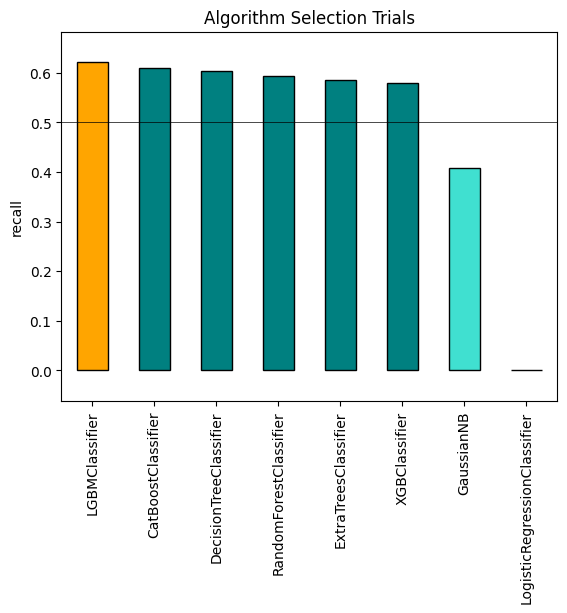

In [28]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[est1.completed_trials_summary_["Step"].str.contains('Model Selection')]
name_of_score_column = f"Score ({est1._inferred_score_metric[0].name})"
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace = True)
scores = trials[name_of_score_column].tolist()
models = trials['Algorithm'].tolist()
colors = []

y_margin = 0.10 * (max(scores) - min(scores))
s = pd.Series(scores, index=models).sort_values(ascending=False)
s = s.dropna()
for f in s.keys():
    if f.strip()  ==  est1.selected_model_.strip():
        colors.append('orange')
    elif s[f] >= s.mean():
        colors.append('teal')
    else:
        colors.append('turquoise')

fig, ax = plt.subplots(1)
ax.set_title("Algorithm Selection Trials")
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.set_ylabel(est1._inferred_score_metric[0].name)
s.plot.bar(ax=ax, color=colors, edgecolor='black')
ax.axhline(y=s.mean(), color='black', linewidth=0.5)
plt.show()
plt.close()

##### Sampling Adaptativo

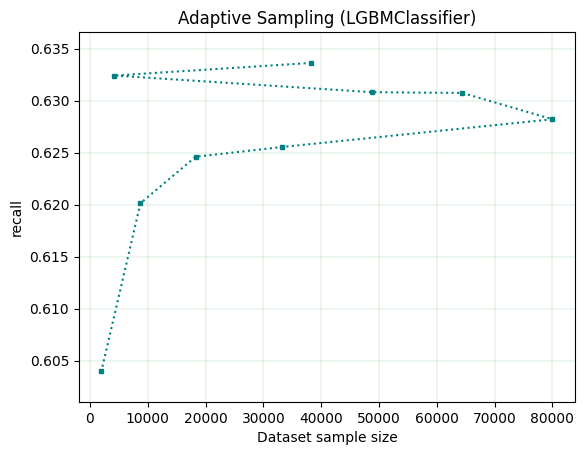

In [29]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[est1.completed_trials_summary_["Step"].str.contains('Adaptive Sampling')]
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace = True)
scores = trials[name_of_score_column].tolist()
n_samples = [int(sum(d.values()) / len(d)) if isinstance(d, dict) else d for d in trials['# Samples']]


y_margin = 0.10 * (max(scores) - min(scores))
fig, ax = plt.subplots(1)
ax.set_title("Adaptive Sampling ({})".format(est1.selected_model_))
ax.set_xlabel('Dataset sample size')
ax.set_ylabel(est1._inferred_score_metric[0].name)
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(n_samples, scores, 'k:', marker="s", color='teal', markersize=3)
plt.show()
plt.close()

##### Seleção de Features

Features selected: ['Aeródromo Destino', 'Aeródromo Origem', 'Código Tipo Linha', 'Data do Voo', 'Data do Voo__day', 'Data do Voo__holiday', 'Data do Voo__month', 'Data do Voo__weekday', 'Data do Voo__year', 'Dia da Semana', 'Empresa Aérea', 'Horario_min']
Features dropped: ['Atrasado']


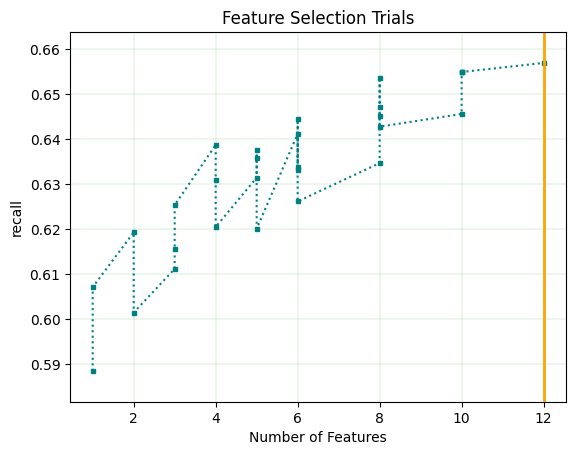

In [30]:
print(f"Features selected: {est1.selected_features_names_}")
dropped_features = df.drop(est1.selected_features_names_raw_, axis=1).columns
print(f"Features dropped: {dropped_features.to_list()}")

# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[est1.completed_trials_summary_["Step"].str.contains('Feature Selection')]
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace = True)
trials.sort_values(by=['# Features'],ascending=True, inplace = True)
scores = trials[name_of_score_column].tolist()
n_features = trials['# Features'].tolist()

y_margin = 0.10 * (max(scores) - min(scores))
fig, ax = plt.subplots(1)
ax.set_title("Feature Selection Trials")
ax.set_xlabel("Number of Features")
ax.set_ylabel(est1._inferred_score_metric[0].name)
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(n_features, scores, 'k:', marker="s", color='teal', markersize=3)
ax.axvline(x=len(est1.selected_features_names_), color='orange', linewidth=2.0)
plt.show()
plt.close()

##### Ajuste de Hiperparâmetros

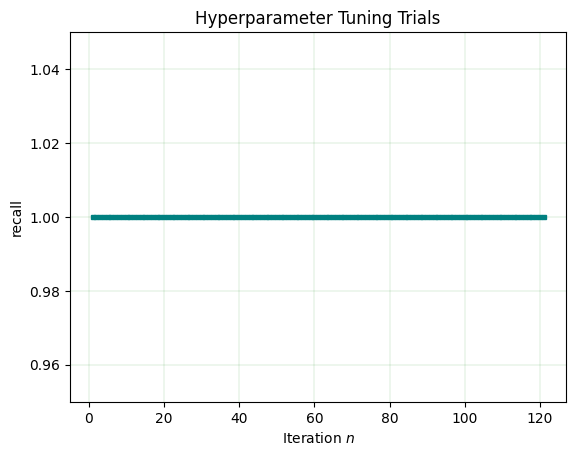

In [31]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[est1.completed_trials_summary_["Step"].str.contains('Model Tuning')]
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace = True)
trials.drop(trials[trials['Finished'] == -1].index, inplace = True)
trials['Finished']= trials['Finished'].apply(lambda x: time.mktime(datetime.datetime.strptime(x,
                                             "%a %b %d %H:%M:%S %Y").timetuple()))
trials.sort_values(by=['Finished'],ascending=True, inplace = True)
scores = trials[name_of_score_column].tolist()
score = []
score.append(scores[0])
for i in range(1,len(scores)):
    if scores[i]>= score[i-1]:
        score.append(scores[i])
    else:
        score.append(score[i-1])
y_margin = 0.10 * (max(score) - min(score))

fig, ax = plt.subplots(1)
ax.set_title("Hyperparameter Tuning Trials")
ax.set_xlabel("Iteration $n$")
ax.set_ylabel(est1._inferred_score_metric[0].name)
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(score) - y_margin, max(score) + y_margin)
ax.plot(range(1, len(trials) + 1), score, 'k:', marker="s", color='teal', markersize=3)
plt.show()
plt.close()

##### Matriz de Confusão

              precision    recall  f1-score   support

           0       0.76      0.77      0.77   2584621
           1       0.60      0.58      0.59   1484669

    accuracy                           0.70   4069290
   macro avg       0.68      0.68      0.68   4069290
weighted avg       0.70      0.70      0.70   4069290



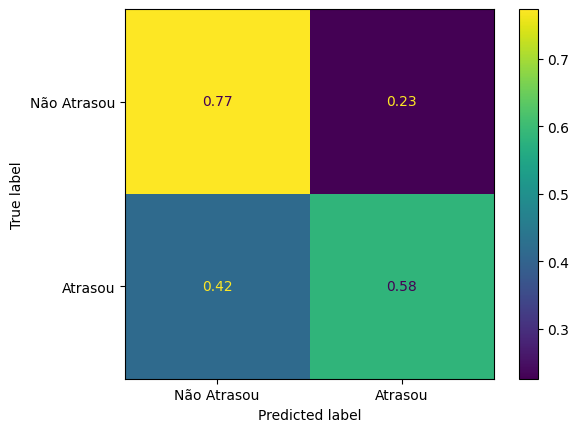

In [42]:
y_pred = est1.predict(X_test)
cm = confusion_matrix(y_test.astype(int), y_pred, labels=[False, True])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Não Atrasou", "Atrasou"]
)

print(classification_report(y_test, y_pred))
disp.plot(cmap="viridis")

In [43]:
(0.77 + 0.58) / 2

0.675